In [1]:
import torch
import math
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict
torch.cuda.is_available()


False

In [2]:
df = pd.read_csv('./twitter_sentiment_data.csv')

df = df[abs(df['sentiment']) == 1]
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == -1 else 1)
df = df.filter(items=['sentiment',"message"])
df = df.rename(columns={'sentiment':'label'})
dataset = Dataset.from_pandas(df)
datset = dataset.shuffle(seed=42)
train = dataset.select([i for i in range(0, int(len(dataset)*0.8))])
test = dataset.select([i for i in range(int(len(dataset)*0.8), len(dataset))])

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [4]:
def preprocess_function(examples):
   return tokenizer(examples["message"], truncation=True)
 
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_test = test.map(preprocess_function, batched=True)

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [5]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [7]:
import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
from transformers import TrainingArguments, Trainer
 
repo_name = "twitter-climate-sentiment-model"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

c:\Users\Hoppenot\Desktop\CDC\model\twitter-climate-sentiment-model is already a clone of https://huggingface.co/XerOpred/twitter-climate-sentiment-model. Make sure you pull the latest changes with `repo.git_pull()`.


In [11]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: message, __index_level_0__. If message, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 21561
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2696


  0%|          | 0/2696 [00:00<?, ?it/s]

{'loss': 0.3043, 'learning_rate': 1.626112759643917e-05, 'epoch': 0.37}
{'loss': 0.2154, 'learning_rate': 1.255192878338279e-05, 'epoch': 0.74}


Saving model checkpoint to twitter-climate-sentiment-model\checkpoint-1348
Configuration saved in twitter-climate-sentiment-model\checkpoint-1348\config.json
Model weights saved in twitter-climate-sentiment-model\checkpoint-1348\pytorch_model.bin
tokenizer config file saved in twitter-climate-sentiment-model\checkpoint-1348\tokenizer_config.json
Special tokens file saved in twitter-climate-sentiment-model\checkpoint-1348\special_tokens_map.json
tokenizer config file saved in twitter-climate-sentiment-model\tokenizer_config.json
Special tokens file saved in twitter-climate-sentiment-model\special_tokens_map.json


NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\Hoppenot\\AppData\\Local\\Temp\\tmptalh9fq9\\lfs_progress'

In [12]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: message, __index_level_0__. If message, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5391
  Batch size = 16


  0%|          | 0/337 [00:00<?, ?it/s]

C:\Users\Hoppenot\AppData\Local\Temp\ipykernel_884\1757224399.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.27790868282318115, 'eval_accuracy': 0.8940827304767205, 'eval_f1': 0.9371629800814351, 'eval_runtime': 135.2041, 'eval_samples_per_second': 39.873, 'eval_steps_per_second': 2.493, 'epoch': 1.0}


{'eval_loss': 0.27790868282318115,
 'eval_accuracy': 0.8940827304767205,
 'eval_f1': 0.9371629800814351,
 'eval_runtime': 135.2041,
 'eval_samples_per_second': 39.873,
 'eval_steps_per_second': 2.493,
 'epoch': 1.0}

In [13]:
trainer.push_to_hub()

Saving model checkpoint to twitter-climate-sentiment-model
Configuration saved in twitter-climate-sentiment-model\config.json
Model weights saved in twitter-climate-sentiment-model\pytorch_model.bin
tokenizer config file saved in twitter-climate-sentiment-model\tokenizer_config.json
Special tokens file saved in twitter-climate-sentiment-model\special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/XerOpred/twitter-climate-sentiment-model
   ee7435a..b3e887b  main -> main



In [16]:
from transformers import pipeline
sentiment_model = pipeline(model="XerOpred/twitter-climate-sentiment-model")
sentiment_model(["RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦"])
maximum = 0
minimum = 1
sums = 0
n = 0
neg = []
for index, row in df.iterrows():
    if(row['label'] == 0):
        v = sentiment_model(row['message'])[0]['score']
        neg.append(v)
        if v > maximum:
            maximum = v
        if v < minimum:
            minimum = v
        sums += v
        n += 1
        if n == 100:
            break
print(sums/n)
print(maximum)
print(minimum)
print("pos")
maximum = 0
minimum = 1
sums = 0
n = 0
pos = []
for index, row in df.iterrows():
    if(row['label'] == 1):
        v = sentiment_model(row['message'])[0]['score']
        pos.append(v)
        if v > maximum:
            maximum = v
        if v < minimum:
            minimum = v
        sums += v
        n += 1
        if n == 100:
            break
print(sums/n)
print(maximum)
print(minimum)


loading configuration file config.json from cache at C:\Users\Hoppenot/.cache\huggingface\hub\models--XerOpred--twitter-climate-sentiment-model\snapshots\b3e887bfc1252b99457740b1686a2b8ff1017dc7\config.json
Model config DistilBertConfig {
  "_name_or_path": "XerOpred/twitter-climate-sentiment-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

loading configuration file config.json from cache at C:\Users\Hoppenot/.cache\huggingface\hub\models--XerOpred--twitter-climate-sentiment-model\snapshots\b3e887bfc1252b99457740b1686a2b8ff1017dc7\config.json
Model config DistilBertConfig {
  "_name_or_path": "XerOpred/twitter-climate-sentiment-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\Hoppenot/.cache\huggingface\hub\models--XerOpred--twitter-climate-se

0.8717246043682099
0.9828757047653198
0.5142467617988586
pos
0.980625352859497
0.997112512588501
0.8374744653701782


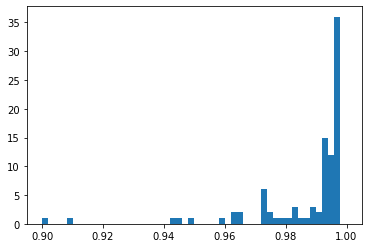

In [24]:
import matplotlib.pyplot as plt
plt.hist(pos,50, range=(0.9,1))

plt.show()

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1.,
        3., 0., 1., 2., 1., 1., 7., 0., 0., 0., 1., 1., 1., 5., 1., 2., 2.,
        1., 4., 8., 5., 5., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.9  , 0.902, 0.904, 0.906, 0.908, 0.91 , 0.912, 0.914, 0.916,
        0.918, 0.92 , 0.922, 0.924, 0.926, 0.928, 0.93 , 0.932, 0.934,
        0.936, 0.938, 0.94 , 0.942, 0.944, 0.946, 0.948, 0.95 , 0.952,
        0.954, 0.956, 0.958, 0.96 , 0.962, 0.964, 0.966, 0.968, 0.97 ,
        0.972, 0.974, 0.976, 0.978, 0.98 , 0.982, 0.984, 0.986, 0.988,
        0.99 , 0.992, 0.994, 0.996, 0.998, 1.   ]),
 <BarContainer object of 50 artists>)

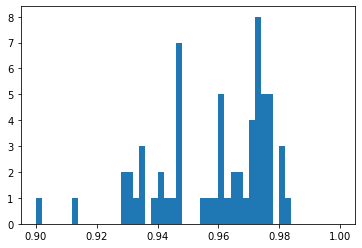

In [25]:
plt.hist(neg, 50, range=(0.9,1))